## Imports

In [1]:
import os
import glob
import random

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from PIL import Image

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.models as tfm
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_csv = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")
test_csv = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")

In [3]:
train_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/train/*") 
test_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/test/*")

In [4]:
filename = train_csv['filename']

situation = train_csv['label']

In [5]:
situation.unique()

array(['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
       'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
       'fighting', 'listening_to_music', 'running', 'texting'],
      dtype=object)

## Loading Images

In [6]:
img_data = []
img_label = []
length = len(train_fol)
for i in (range(len(train_fol)-1)):
    t = '../input/human-action-recognition-har-dataset/Human Action Recognition/train/' + filename[i]    
    temp_img = Image.open(t)
    img_data.append(np.asarray(temp_img.resize((160,160))))
    img_label.append(situation[i])

## Visualie random image from each class

In [7]:
def disp():
    categories = ['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
       'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
       'fighting', 'listening_to_music', 'running', 'texting'] 
    
    num_columns = 5  
    num_rows = 3
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

    axes = axes.flatten()

    for i, cat in enumerate(categories):
        images = train_csv[train_csv['label'] == cat]['filename']
        sample = images.sample(1)
        imgg = sample
        imgg = imgg.tolist()[0]
        train = "../input/human-action-recognition-har-dataset/Human Action Recognition/train/"
        img = mpimg.imread(train+imgg)
        axes[i].imshow(img)
        axes[i].set_title(cat)
      

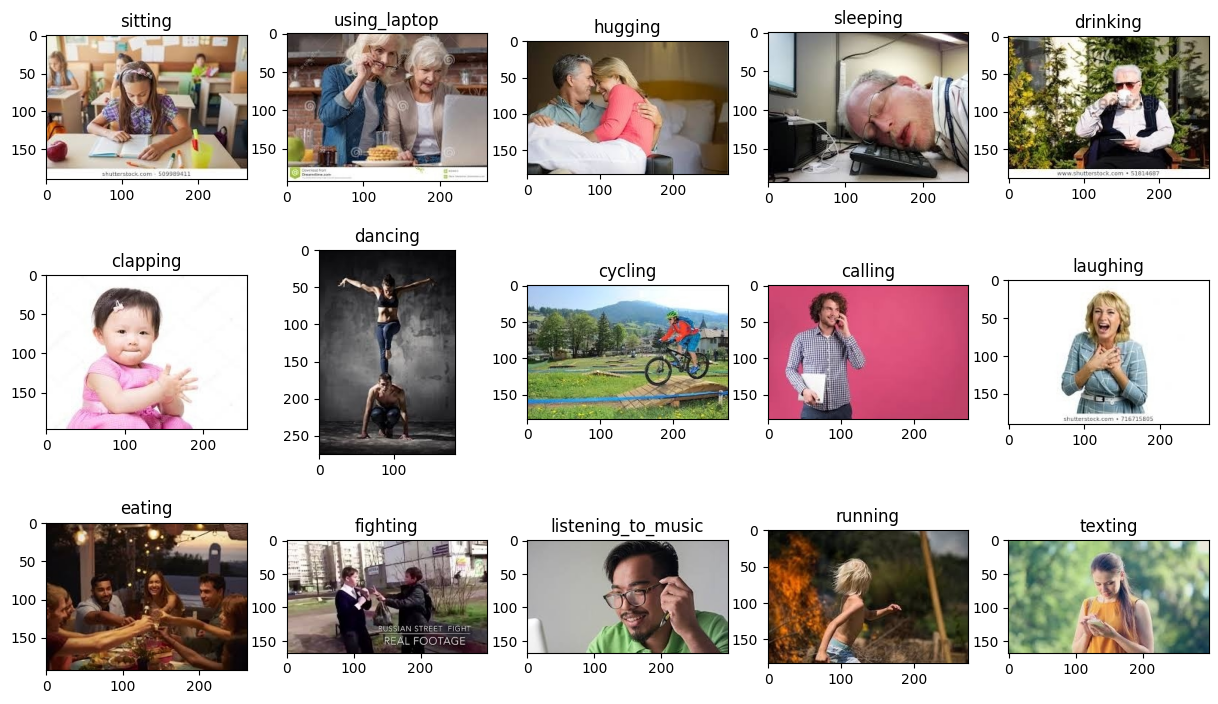

In [8]:
disp()

In [9]:
input_shape = (160, 160,3)

In [10]:
X = np.asarray(img_data)
y = np.asarray(train_csv['label'].factorize()[0])
X = preprocess_input(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

## Feature Extraction

In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3) , classes=15)


In [12]:
X_train.shape

(9828, 160, 160, 3)

In [13]:
features = base_model.predict(X_train)

308/308 [==============================] - 14s 20ms/step


In [14]:
features.shape

(9828, 5, 5, 1280)

In [15]:
features = features.reshape(features.shape[0] , features.shape[1] * features.shape[2] * features.shape[3])

In [16]:
features.shape

(9828, 32000)

In [17]:
print(y_train.shape)
print(set(y_train))

(9828,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


## Feature Selection

In [18]:
k_best = 2048  # Adjust as needed
selector = SelectKBest(score_func=mutual_info_classif, k=k_best)

In [19]:
X_train_selected = selector.fit_transform(features, y_train)

selected_features = selector.get_support()
np.sum(selected_features==True)

2048

In [20]:
X_test_mobnet = base_model.predict(X_test)
X_test_mobnet = X_test_mobnet.reshape(X_test_mobnet.shape[0] , X_test_mobnet.shape[1] * X_test_mobnet.shape[2] * X_test_mobnet.shape[3])
x_test_selected = selector.transform(X_test_mobnet)

87/87 [==============================] - 2s 24ms/step


## Modeling

In [42]:
svm_model = SVC(kernel='poly')  # You can choose different kernels based on your problem
svm_model.fit(X_train_selected, y_train)

SVC(kernel='poly')

In [43]:
y_pred = svm_model.predict(x_test_selected)

In [44]:
np.mean(y_pred == y_test)

0.63997113997114

## Classification Report

In [45]:
print(classification_report(y_test  , y_pred))

              precision    recall  f1-score   support

           0       0.51      0.50      0.51       178
           1       0.65      0.69      0.67       176
           2       0.51      0.64      0.57       163
           3       0.76      0.74      0.75       185
           4       0.66      0.60      0.63       171
           5       0.64      0.59      0.62       170
           6       0.69      0.78      0.73       205
           7       0.95      0.92      0.94       205
           8       0.47      0.38      0.42       187
           9       0.46      0.70      0.56       192
          10       0.83      0.86      0.84       172
          11       0.73      0.68      0.70       198
          12       0.42      0.34      0.38       199
          13       0.79      0.75      0.77       172
          14       0.56      0.43      0.48       199

    accuracy                           0.64      2772
   macro avg       0.64      0.64      0.64      2772
weighted avg       0.64   

<Axes: >

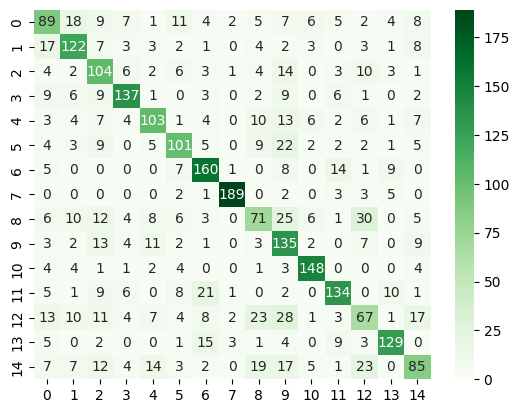

In [46]:
convmat = confusion_matrix(y_test , y_pred)
sns.heatmap(convmat , annot=True , fmt='d',cmap = 'Greens')